# TODO:

Try:

* Different models:
  * Sarsa Linear (done)
  * Sarsa ANN (done)
  * Q-learning Linear?
  * Q-learning ANN without experience replay
  * Q-learning ANN with experience replay
  * Q-learning ANN with experience replay and policy/target network split?
* Different loss functions:
  * MSE -> leads to updates as in Sutton, Barto
  * SmoothL1?
  * What do they use in DQN paper?

In [1]:
import sys
sys.path.append("..")
from rl_utils import *
from cart_pole import *

# Settings

In [2]:
ENVIRONMENT_ID = "CartPole-v1"
NUM_EPISODES = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", device)

PyTorch device: cuda


# Sarsa

## Linear model

Average return per episode: 21.631


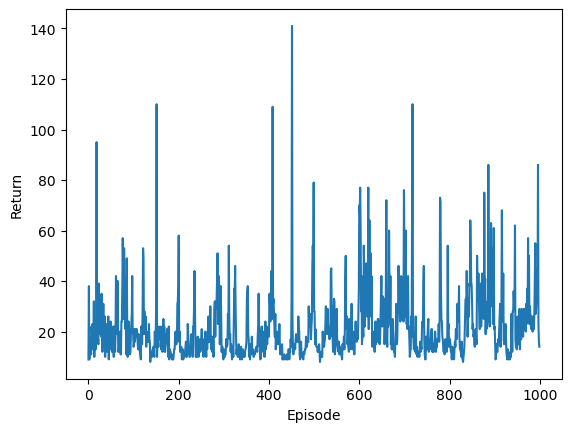

In [3]:
env = gym.make(ENVIRONMENT_ID)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_sarsa(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

## Simple Neural Network

In [ ]:
env = gym.make(ENVIRONMENT_ID)
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, env.action_space.n)
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_sarsa(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

# Q-learning

## Linear model

In [ ]:
env = gym.make(ENVIRONMENT_ID)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_qlearning(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

## Simple Neural Network

In [ ]:
env = gym.make(ENVIRONMENT_ID)
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, env.action_space.n)
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_qlearning(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

# Q-learning with experience replay

## Linear Model

In [ ]:
def train_episodic_semi_gradient_qlearning_experience_replay(env, model, loss_func, optimizer, device, num_episodes, memory_size):
    eps = 1
    returns = []
    replay_memory = ReplayMemory(memory_size)
    for ep in range(num_episodes):
        observation, info = env.reset()
        truncated = False
        terminated = False
        G = 0

        while not (terminated or truncated):
            action = select_action_eps_greedy(env, model, torch.tensor(observation, device=device), eps)
            next_observation, reward, terminated, truncated, info = env.step(action)
            replay_memory.store(observation, action, reward, next_observation)
            G += reward

            if terminated:
                
            else:
                observation = next_observation

        eps = update_eps(eps)
        returns.append(G)
    return returns

In [25]:
replay_memory = ReplayMemory(2)
replay_memory.store(torch.tensor((0, 0, 0, 0), dtype=torch.float32, device=device).unsqueeze(0), 0, 0, torch.tensor((1, 1, 1, 1), dtype=torch.float32, device=device).unsqueeze(0))
replay_memory.store(torch.tensor((2, 2, 2, 2), dtype=torch.float32, device=device).unsqueeze(0), 1, 1, torch.tensor((3, 3, 3, 3), dtype=torch.float32, device=device).unsqueeze(0))
replay_memory.store(torch.tensor((4, 4, 4, 4), dtype=torch.float32, device=device).unsqueeze(0), 2, 2, torch.tensor((5, 5, 5, 5), dtype=torch.float32, device=device).unsqueeze(0))
state_batch, action_batch, reward_batch, next_state_batch = replay_memory.sample_batch(2)
print("state_batch")
print(state_batch)
print("action_batch")
print(action_batch)
print("reward_batch")
print(reward_batch)
print("next_state_batch")
print(next_state_batch)

state_batch
(tensor([[2., 2., 2., 2.]], device='cuda:0'), tensor([[4., 4., 4., 4.]], device='cuda:0'))
action_batch
(1, 2)
reward_batch
(1, 2)
next_state_batch
(tensor([[3., 3., 3., 3.]], device='cuda:0'), tensor([[5., 5., 5., 5.]], device='cuda:0'))


In [26]:
torch.cat(state_batch)

tensor([[2., 2., 2., 2.],
        [4., 4., 4., 4.]], device='cuda:0')

In [28]:
model(torch.cat(state_batch))

tensor([[54.9502, 12.2559],
        [83.3538,  1.2189]], device='cuda:0', grad_fn=<AddmmBackward0>)